## ELETTRA-06: ID tune shift correction (global tune knob)

In [1]:
# In this example effects of an ID (APPLE-II device represented by a linear 4x4 symplectic matrix) are presented

# Tune shift introduced by ID is corrected using model tune response matrix

In [2]:
# Import

import torch
from torch import Tensor

from pathlib import Path

import matplotlib
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle
matplotlib.rcParams['text.usetex'] = True

from model.library.element import Element
from model.library.line import Line
from model.library.quadrupole import Quadrupole
from model.library.matrix import Matrix

from model.command.external import load_lattice
from model.command.build import build
from model.command.tune import tune
from model.command.orbit import dispersion
from model.command.twiss import twiss
from model.command.advance import advance
from model.command.coupling import coupling

In [3]:
# Set data type and device

Element.dtype = dtype = torch.float64
Element.device = device = torch.device('cpu')

In [4]:
# Load lattice (ELEGANT table)
# Note, lattice is allowed to have repeated elements

path = Path('elettra.lte')
data = load_lattice(path)

In [5]:
# Build and setup lattice

ring:Line = build('RING', 'ELEGANT', data)

# Flatten sublines

ring.flatten()

# Remove all marker elements but the ones starting with MLL (long straight section centers)

ring.remove_group(pattern=r'^(?!MLL_).*', kinds=['Marker'])

# Replace all sextupoles with quadrupoles

def factory(element:Element) -> None:
    table = element.serialize
    table.pop('ms', None)
    return Quadrupole(**table)

ring.replace_group(pattern=r'', factory=factory, kinds=['Sextupole'])

# Set linear dipoles

def apply(element:Element) -> None:
    element.linear = True

ring.apply(apply, kinds=['Dipole'])

# Merge drifts

ring.merge()

# Change lattice start

ring.start = "BPM_S01_01"

# Split BPMs

ring.split((None, ['BPM'], None, None))

# Roll lattice

ring.roll(1)

# Splice lattice

ring.splice()

# Describe

ring.describe

{'BPM': 168, 'Drift': 708, 'Dipole': 156, 'Quadrupole': 360, 'Marker': 12}

In [6]:
# Compute tunes (fractional part)

nux, nuy = tune(ring, [], matched=True, limit=1)

In [7]:
# Compute dispersion

orbit = torch.tensor(4*[0.0], dtype=dtype)
etaqx, etapx, etaqy, etapy = dispersion(ring, orbit, [], limit=1)

In [8]:
# Compute twiss parameters

ax, bx, ay, by = twiss(ring, [], matched=True, advance=True, full=False).T

In [9]:
# Compute phase advances

mux, muy = advance(ring, [], alignment=False, matched=True).T

In [10]:
# Compute coupling

c = coupling(ring, [])

In [11]:
# Quadrupole names for global tune correction

QF = [f'QF_S{i:02}_{j:02}' for j in [2, 3] for i in range(1, 12 + 1)]
QD = [f'QD_S{i:02}_{j:02}' for j in [2, 3] for i in range(1, 12 + 1)]

In [12]:
# Compute model tune response matrix

def observable(kn):
    return tune(ring, [kn], ('kn', None, QF + QD, None), matched=True, limit=1)

kn = torch.zeros(len(QF + QD), dtype=torch.float64)
matrix = torch.func.jacrev(observable)(kn)

In [13]:
# Define ID model
# Note, only the flattened triangular part of the A and B matrices is passed

A = torch.tensor([[-0.03484222052711237, 1.0272120741819959E-7, -4.698931299341201E-9, 0.0015923185492594811],
                  [1.0272120579834892E-7, -0.046082787920135176, 0.0017792061173117564, 3.3551298301095784E-8],
                  [-4.6989312853101E-9, 0.0017792061173117072, 0.056853750760983084, -1.5929605363332683E-7],
                  [0.0015923185492594336, 3.3551298348653296E-8, -1.5929605261642905E-7, 0.08311631737263032]], dtype=dtype)

B = torch.tensor([[0.03649353186115209, 0.0015448347221877217, 0.00002719892025520868, -0.0033681183134964482],
                  [0.0015448347221877217, 0.13683886657005795, -0.0033198692682377406, 0.00006140578258682469],
                  [0.00002719892025520868, -0.0033198692682377406, -0.05260095308967722, 0.005019907688182885],
                  [-0.0033681183134964482, 0.00006140578258682469, 0.005019907688182885, -0.2531573249456863]], dtype=dtype)

ID = Matrix('ID', 
            length=0.0, 
            A=A[torch.triu(torch.ones_like(A, dtype=torch.bool))].tolist(), 
            B=B[torch.triu(torch.ones_like(B, dtype=torch.bool))].tolist())

In [14]:
# Insert ID into the existing lattice
# This will replace the target marker

ring.flatten()
ring.insert(ID, 'MLL_S01', position=0.0)
ring.splice()

# Describe

ring.describe

{'BPM': 168,
 'Drift': 708,
 'Dipole': 156,
 'Quadrupole': 360,
 'Matrix': 1,
 'Marker': 11}

In [15]:
# Compute tunes (fractional part)

nux_id, nuy_id = tune(ring, [], matched=True, limit=1)

In [16]:
# Compute dispersion

orbit = torch.tensor(4*[0.0], dtype=dtype)
etaqx_id, etapx_id, etaqy_id, etapy_id = dispersion(ring, orbit, [], limit=1)

In [17]:
# Compute twiss parameters

ax_id, bx_id, ay_id, by_id = twiss(ring, [], matched=True, advance=True, full=False).T

In [18]:
# Compute phase advances

mux_id, muy_id = advance(ring, [], alignment=False, matched=True).T

In [19]:
# Compute coupling

c_id = coupling(ring, [])

In [20]:
# Parametric tunes (emulate tune measurement)

def observable(kn):
    return tune(ring, [kn], ('kn', None, QF + QD, None), matched=True, limit=1)

In [21]:
# Tune correction
# Observe tunes for lattice with errors (inserted ID) while adjusting quadrupoles using model response matrix
# With this method the ID model is not required, but several rounds of observable measurement are performed

lr = 0.75
kn = torch.zeros(len(QF + QD), dtype=torch.float64)
target = torch.stack([nux, nuy])

for _ in range(16):
    value = observable(kn)
    kn -= lr*torch.linalg.lstsq(matrix, value - target, driver='gels').solution
    print((value - target).norm())
print()

tensor(0.0284, dtype=torch.float64)
tensor(0.0067, dtype=torch.float64)
tensor(0.0016, dtype=torch.float64)
tensor(0.0004, dtype=torch.float64)
tensor(9.4026e-05, dtype=torch.float64)
tensor(2.2813e-05, dtype=torch.float64)
tensor(5.5475e-06, dtype=torch.float64)
tensor(1.3520e-06, dtype=torch.float64)
tensor(3.3015e-07, dtype=torch.float64)
tensor(8.0778e-08, dtype=torch.float64)
tensor(1.9800e-08, dtype=torch.float64)
tensor(4.8613e-09, dtype=torch.float64)
tensor(1.1954e-09, dtype=torch.float64)
tensor(2.9439e-10, dtype=torch.float64)
tensor(7.2593e-11, dtype=torch.float64)
tensor(1.7923e-11, dtype=torch.float64)



In [22]:
# Apply corrections

ring.flatten()
for name, value in zip(QF + QD, kn):
    ring[name].kn = (ring[name].kn + value).item()
ring.splice()

In [23]:
# Compute tunes (fractional part)

nux_c, nuy_c = tune(ring, [], matched=True, limit=1)

In [24]:
# Compute dispersion

orbit = torch.tensor(4*[0.0], dtype=dtype)
etaqx_c, etapx_c, etaqy_c, etapy_c = dispersion(ring, orbit, [], limit=1)

In [25]:
# Compute twiss parameters

ax_c, bx_c, ay_c, by_c = twiss(ring, [], matched=True, advance=True, full=False).T

In [26]:
# Compute phase advances

mux_c, muy_c = advance(ring, [], alignment=False, matched=True).T

In [27]:
# Compute coupling

c_c = coupling(ring, [])

In [28]:
# Tune shifts

print((nux - nux_id).abs())
print((nuy - nuy_id).abs())
print()

print((nux - nux_c).abs())
print((nuy - nuy_c).abs())
print()

tensor(0.0260, dtype=torch.float64)
tensor(0.0114, dtype=torch.float64)

tensor(3.2221e-12, dtype=torch.float64)
tensor(3.0445e-12, dtype=torch.float64)



In [29]:
# Coupling (minimal tune distance)

print(c)
print(c_id)
print(c_c)

tensor(0., dtype=torch.float64)
tensor(0.0004, dtype=torch.float64)
tensor(0.0004, dtype=torch.float64)


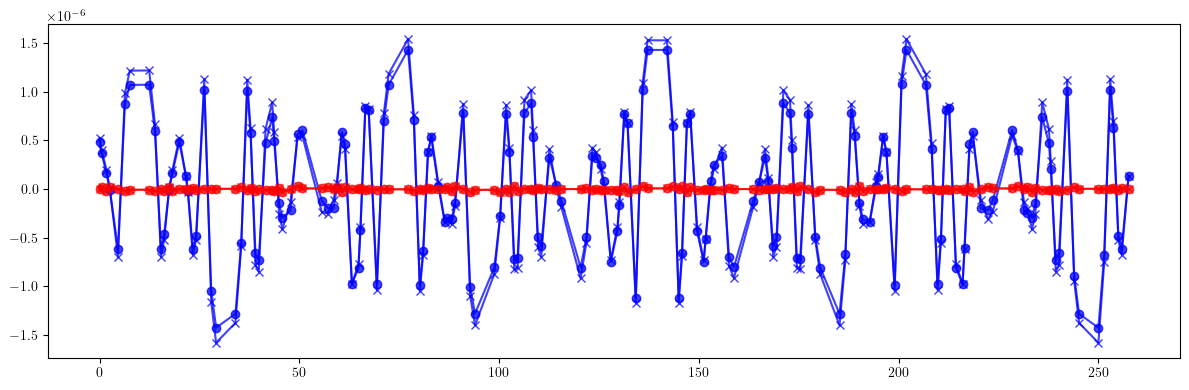

tensor(7.4928e-07, dtype=torch.float64) tensor(3.1227e-06, dtype=torch.float64)
tensor(1.4168e-08, dtype=torch.float64) tensor(6.0573e-08, dtype=torch.float64)

tensor(6.8912e-07, dtype=torch.float64) tensor(2.8567e-06, dtype=torch.float64)
tensor(1.4789e-08, dtype=torch.float64) tensor(6.3260e-08, dtype=torch.float64)



In [30]:
# Dispersion

plt.figure(figsize=(12, 4))
plt.errorbar(ring.locations().cpu().numpy(), (etaqx - etaqx_id).cpu().numpy(), fmt='-', marker='x', color='blue', alpha=0.75)
plt.errorbar(ring.locations().cpu().numpy(), (etaqy - etaqy_id).cpu().numpy(), fmt='-', marker='x', color='red', alpha=0.75)
plt.errorbar(ring.locations().cpu().numpy(), (etaqx - etaqx_c).cpu().numpy(), fmt='-', marker='o', color='blue', alpha=0.75)
plt.errorbar(ring.locations().cpu().numpy(), (etaqy - etaqy_c).cpu().numpy(), fmt='-', marker='o', color='red', alpha=0.75)

plt.tight_layout()
plt.show()

print(((etaqx - etaqx_id)**2).mean().sqrt(), (etaqx - etaqx_id).max() - (etaqx - etaqx_id).min())
print(((etaqy - etaqy_id)**2).mean().sqrt(), (etaqy - etaqy_id).max() - (etaqy - etaqy_id).min())
print()

print(((etaqx - etaqx_c)**2).mean().sqrt(), (etaqx - etaqx_c).max() - (etaqx - etaqx_c).min())
print(((etaqy - etaqy_c)**2).mean().sqrt(), (etaqy - etaqy_c).max() - (etaqy - etaqy_c).min())
print()

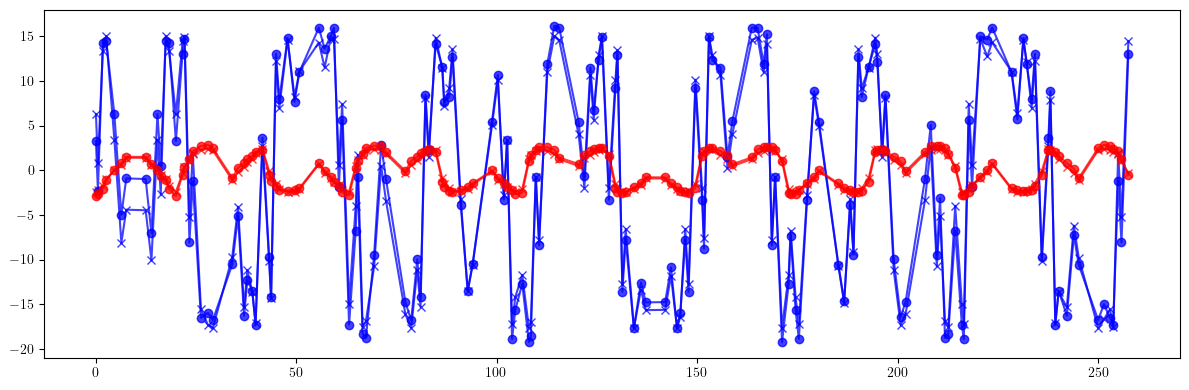

tensor(11.5994, dtype=torch.float64) tensor(32.6569, dtype=torch.float64)
tensor(1.7916, dtype=torch.float64) tensor(4.8154, dtype=torch.float64)

tensor(11.8471, dtype=torch.float64) tensor(35.3888, dtype=torch.float64)
tensor(1.9331, dtype=torch.float64) tensor(5.7332, dtype=torch.float64)



In [31]:
# Beta-beating

plt.figure(figsize=(12, 4))
plt.errorbar(ring.locations().cpu().numpy(), 100*((bx - bx_id)/bx).cpu().numpy(), fmt='-', marker='x', color='blue', alpha=0.75)
plt.errorbar(ring.locations().cpu().numpy(), 100*((by - by_id)/by).cpu().numpy(), fmt='-', marker='x', color='red', alpha=0.75)
plt.errorbar(ring.locations().cpu().numpy(), 100*((bx - bx_c)/bx).cpu().numpy(), fmt='-', marker='o', color='blue', alpha=0.75)
plt.errorbar(ring.locations().cpu().numpy(), 100*((by - by_c)/by).cpu().numpy(), fmt='-', marker='o', color='red', alpha=0.75)
plt.tight_layout()
plt.show()

print(100*(((bx - bx_id)/bx)**2).mean().sqrt(), 100*(((bx - bx_id)/bx).max() - ((bx - bx_id)/bx).min()))
print(100*(((by - by_id)/by)**2).mean().sqrt(), 100*(((by - by_id)/by).max() - ((by - by_id)/by).min()))
print()

print(100*(((bx - bx_c)/bx)**2).mean().sqrt(), 100*(((bx - bx_c)/bx).max() - ((bx - bx_c)/bx).min()))
print(100*(((by - by_c)/by)**2).mean().sqrt(), 100*(((by - by_c)/by).max() - ((by - by_c)/by).min()))
print()

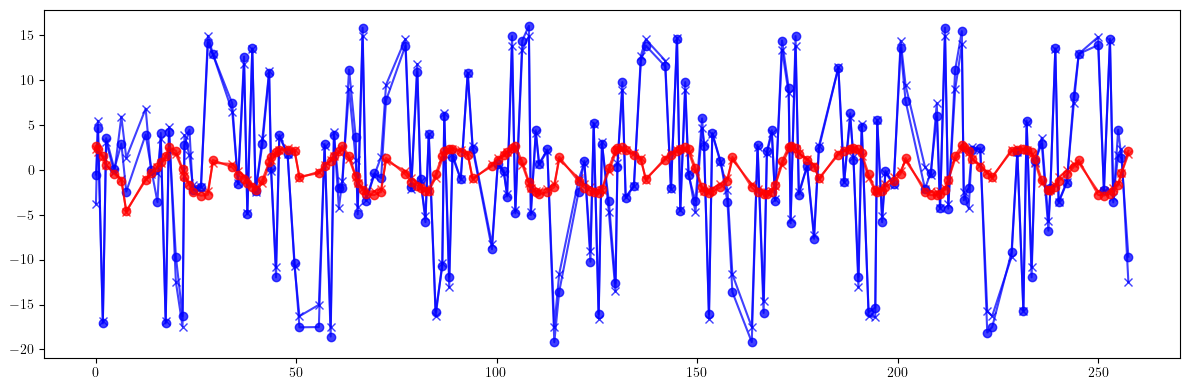

tensor(8.7941, dtype=torch.float64) tensor(32.4432, dtype=torch.float64)
tensor(1.7778, dtype=torch.float64) tensor(7.0609, dtype=torch.float64)

tensor(8.9663, dtype=torch.float64) tensor(35.2147, dtype=torch.float64)
tensor(1.9193, dtype=torch.float64) tensor(7.3238, dtype=torch.float64)



In [32]:
# Phase advance

plt.figure(figsize=(12, 4))
plt.errorbar(ring.locations().cpu().numpy(), 100*((mux - mux_id)/mux).cpu().numpy(), fmt='-', marker='x', color='blue', alpha=0.75)
plt.errorbar(ring.locations().cpu().numpy(), 100*((muy - muy_id)/muy).cpu().numpy(), fmt='-', marker='x', color='red', alpha=0.75)
plt.errorbar(ring.locations().cpu().numpy(), 100*((mux - mux_c)/mux).cpu().numpy(), fmt='-', marker='o', color='blue', alpha=0.75)
plt.errorbar(ring.locations().cpu().numpy(), 100*((muy - muy_c)/muy).cpu().numpy(), fmt='-', marker='o', color='red', alpha=0.75)
plt.tight_layout()
plt.show()

print(100*(((mux - mux_id)/mux)**2).mean().sqrt(), 100*(((mux - mux_id)/mux).max() - ((mux - mux_id)/mux).min()))
print(100*(((muy - muy_id)/muy)**2).mean().sqrt(), 100*(((muy - muy_id)/muy).max() - ((muy - muy_id)/muy).min()))
print()

print(100*(((mux - mux_c)/mux)**2).mean().sqrt(), 100*(((mux - mux_c)/mux).max() - ((mux - mux_c)/mux).min()))
print(100*(((muy - muy_c)/muy)**2).mean().sqrt(), 100*(((muy - muy_c)/muy).max() - ((muy - muy_c)/muy).min()))
print()